# VADs testings

In [1]:
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import torch
import torchaudio
import librosa
import numpy as np
import webrtcvad
from scipy.signal import find_peaks

# Опционально: Проверяем доступность SpeechBrain и OpenVINO
try:
    from speechbrain.pretrained import VAD as SpeechBrainVAD
except ImportError:
    print('cant import SpeechBrainVAD')
    SpeechBrainVAD = None

try:
    from openvino.runtime import Core
except ImportError:
    print('cant import openvino')
    Core = None


c:\Users\Bogdan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Bogdan\AppData\Local\Programs\Python\Python311\Lib\inspect.py:992: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_13796\990377766.py:10: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import VAD as SpeechBr

In [19]:

class VADInterface:
    def __init__(self, model_type="webrtc", aggressiveness=3):
        self.model_type = model_type

        if model_type == "webrtc":
            self.vad = webrtcvad.Vad(aggressiveness)
        elif model_type == "silero":
            self.model, _ = torch.hub.load('snakers4/silero-vad', 'silero_vad')
        elif model_type == "torchaudio":
            pass  # Используем torchaudio.functional.vad напрямую
        elif model_type == "librosa":
            pass  # Не требуется загрузка модели
        elif model_type == "speechbrain" and SpeechBrainVAD:
            self.model = SpeechBrainVAD.from_hparams(
                source="speechbrain/vad-crdnn-libriparty", savedir="tmp"
            )
        elif model_type == "openvino" and Core:
            self.core = Core()
            self.model = self.core.read_model("vad_model.xml")  # Укажите путь к вашей модели
            self.compiled_model = self.core.compile_model(self.model, "CPU")
        else:
            raise ValueError(f"Unsupported or unavailable VAD type: {model_type}")

    def apply_vad(self, waveform, sample_rate):
        if self.model_type == "webrtc":
            return self._webrtc_vad(waveform, sample_rate)
        elif self.model_type == "silero":
            return self._silero_vad(waveform, sample_rate)
        elif self.model_type == "torchaudio":
            return torchaudio.functional.vad(waveform, sample_rate, search_time=3)
        elif self.model_type == "librosa":
            return self._librosa_vad(waveform, sample_rate)
        elif self.model_type == "speechbrain":
            return self._speechbrain_vad("audio.wav")  # SpeechBrain работает с файлами
        elif self.model_type == "openvino":
            return self._openvino_vad(waveform)

    def _webrtc_vad(self, waveform, sample_rate):
        frame_size = int(sample_rate * 0.02)  # 20ms frames
        return torch.cat([
            waveform[:, i:i + frame_size]
            for i in range(0, waveform.shape[1], frame_size)
            if self.vad.is_speech(waveform[:, i:i + frame_size].numpy().tobytes(), sample_rate)
        ], dim=1)

    def _silero_vad(self, waveform, sample_rate):
        waveform=waveform[0]
        ub = (len(waveform) // 512)*512
        full = []
        for i in range(0, len(waveform[:ub]), 512):
            res = self.model(waveform[i:i+512], 16000)
            full += [res.detach().numpy()]*512
        
        speech_probs = np.array(full)[:,0, 0]
        
        mask = speech_probs > 0.5
        return mask
        return waveform[:ub][mask]

    def _librosa_vad(self, waveform, sample_rate):
        '''"""Простая реализация VAD с использованием RMS энергии."""
        energy = librosa.feature.rms(y=waveform.numpy().flatten())
        threshold = np.mean(energy) * 0.5  # Эвристический порог
        mask = energy.flatten() > threshold
        print(mask.shape)
        print(energy.shape)
        peaks, _ = find_peaks(mask)  # Находим интервалы активной речи
        return waveform[:, peaks]'''
        frame_length = 2048 #60504
        hop_length = 512
        # Разделение на фреймы
        def frame_signal(waveform, frame_length, hop_length):
            return waveform.unfold(1, frame_length, hop_length)

        framed_signal = frame_signal(waveform, frame_length, hop_length)
        energies = torch.sum(framed_signal**2, dim=2)

        # Определение активных участков
        energy_threshold = np.median(energies) * 1.3#0.02
        vad_mask = energies > energy_threshold
        return np.repeat(vad_mask, hop_length)
        return vad_mask

    '''def _speechbrain_vad(self, filepath):
        """VAD с использованием SpeechBrain."""
        boundaries = self.model.get_speech_segments(filepath)
        print(f"Speech segments: {boundaries}")
        return boundaries

    def _openvino_vad(self, waveform):
        """VAD с использованием OpenVINO."""
        inputs = {self.model.inputs[0]: waveform.numpy()}
        result = self.compiled_model(inputs)[self.model.outputs[0]]
        mask = result.squeeze() > 0.5  # Бинаризуем результаты
        return waveform[:, mask]'''



def plot_waveforms(original, processed_list, sample_rate, labels):
    """Визуализирует оригинальное и обработанное аудио."""
    plt.figure(figsize=(12, 6))
    time = np.linspace(0, len(original[0]) / sample_rate, len(original[0]))

    plt.plot(time, original[0].numpy(), label="Original", alpha=0.6)
    for processed, label in zip(processed_list, labels):
        plt.plot(time[:len(processed[0])], processed[0].numpy(), label=label, alpha=0.6)

    plt.legend()
    plt.title("VAD Comparison")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()





In [4]:
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from scipy import signal

def load_audio(filepath):
    """Load audio using torchaudio."""
    waveform, sample_rate = torchaudio.load(filepath)
    return waveform, sample_rate

def add_white_noise(waveform, noise_factor=0.005):
    """Add white noise to the waveform."""
    noise = np.random.normal(0, noise_factor, waveform.shape)
    return waveform + torch.from_numpy(noise).float()

def add_pink_noise(waveform, noise_factor=0.005):
    """Add pink noise to the waveform."""
    n_samples = waveform.shape[1]
    uneven = n_samples % 2
    X = np.random.randn(n_samples // 2 + 1 + uneven) + 1j * np.random.randn(n_samples // 2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)  # 1/f frequency scaling
    y = (np.fft.irfft(X / S)).real
    pink_noise = np.tile(y[:n_samples], (waveform.shape[0], 1))
    return waveform + noise_factor * torch.from_numpy(pink_noise).float()

def add_brown_noise(waveform, noise_factor=0.005):
    """Add brown noise to the waveform."""
    n = np.cumsum(np.random.randn(waveform.shape[1]))  # Brownian motion
    brown_noise = n / np.max(np.abs(n))  # Normalize
    return waveform + noise_factor * torch.from_numpy(brown_noise).float()

def add_gaussian_noise(waveform, noise_factor=0.005):
    """Add Gaussian noise to the waveform."""
    noise = np.random.normal(0, noise_factor, waveform.shape)
    return waveform + torch.from_numpy(noise).float()

def plot_waveforms(original, noisy, sample_rate, title):
    """Plot original and noisy audio signals."""
    plt.figure(figsize=(12, 4))
    time = np.linspace(0, len(original[0]) / sample_rate, len(original[0]))

    plt.plot(time, original[0].numpy(), label="Original", alpha=0.6)
    plt.plot(time, noisy[0].numpy(), label="Noisy", alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def test_noise():
    # Load an audio file
    original, sample_rate = load_audio("original.wav")

    # Add various types of noise
    noisy_white = add_white_noise(original, noise_factor=0.01)
    noisy_pink = add_pink_noise(original, noise_factor=0.01)
    noisy_brown = add_brown_noise(original, noise_factor=0.01)
    noisy_gaussian = add_gaussian_noise(original, noise_factor=0.01)

    # Plot the results for comparison
    plot_waveforms(original, noisy_white, sample_rate, "White Noise")
    plot_waveforms(original, noisy_pink, sample_rate, "Pink Noise")
    plot_waveforms(original, noisy_brown, sample_rate, "Brown Noise")
    plot_waveforms(original, noisy_gaussian, sample_rate, "Gaussian Noise")


In [5]:
import os 
import torchaudio

In [6]:
import importlib
importlib.reload(torchaudio)

<module 'torchaudio' from 'c:\\Users\\Bogdan\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\torchaudio\\__init__.py'>

In [7]:
path = os.path.join("vinograd2.wav")

torchaudio.load(path)

(tensor([[-0.0006, -0.0087, -0.0026,  ..., -0.0011, -0.0012, -0.0033]]), 16000)

In [20]:
path = os.path.join("vinograd2.wav")

original, sample_rate = load_audio(path) #waveform, sample_rate
noisy = add_pink_noise(original, noise_factor=0.005)


# Инициализация и применение VAD для разных моделей
#vad_webrtc = VADInterface(model_type="webrtc")
vad_silero = VADInterface(model_type="silero")
vad_torchaudio = VADInterface(model_type="torchaudio")
vad_librosa = VADInterface(model_type="librosa")
#vad_speechbrain = VADInterface(model_type="speechbrain") if SpeechBrainVAD else None

#processed_webrtc = vad_webrtc.apply_vad(original, sample_rate)
processed_silero = vad_silero.apply_vad(original, sample_rate)
processed_torchaudio = vad_torchaudio.apply_vad(original, sample_rate)
processed_librosa = vad_librosa.apply_vad(original, sample_rate)

# Список обработанных сигналов и их меток
processed_list = [ processed_silero, processed_torchaudio, processed_librosa]
labels = ["Silero", "Torchaudio", "Librosa"]

'''
# Визуализация результатов
plot_waveforms(original, processed_list, sample_rate, labels)'''

Using cache found in C:\Users\Bogdan/.cache\torch\hub\snakers4_silero-vad_master


'\n# Визуализация результатов\nplot_waveforms(original, processed_list, sample_rate, labels)'

In [10]:
print('orig shape', original.shape)
for i in processed_list:
    print(i.shape)

orig shape torch.Size([1, 60504])
(60416,)
torch.Size([1, 55704])
torch.Size([58880])


In [11]:
print(processed_silero, processed_torchaudio, processed_librosa, sep='\n')
# все кроме торчаудио это маски 

[False False False ... False False False]
tensor([[ 0.0166,  0.0144,  0.0144,  ..., -0.0011, -0.0012, -0.0033]])
tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)


In [61]:
processed_silero.shape, sum(processed_silero)

((60416,), 60416)

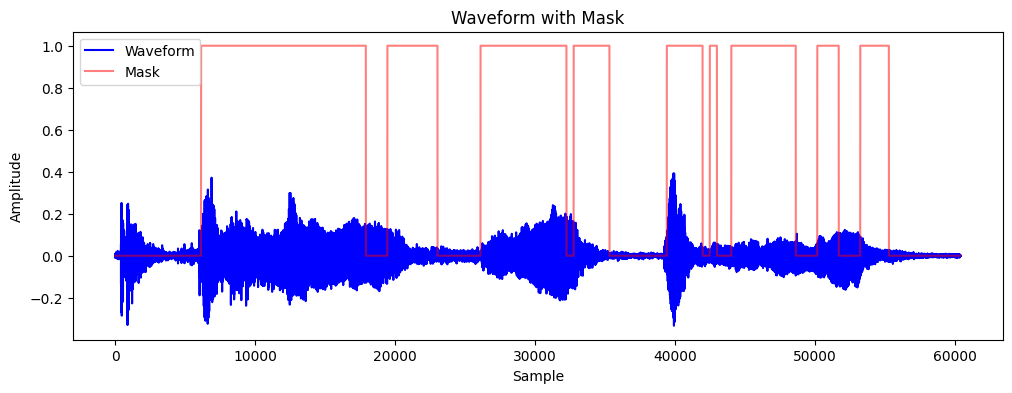

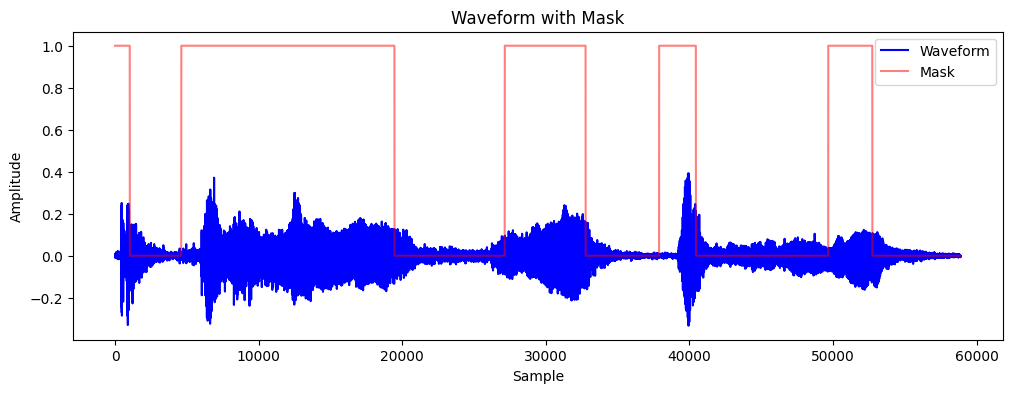

In [12]:
def plot_waveform_with_mask(waveform, mask, sample_rate=16000):
    plt.figure(figsize=(12, 4))

    # Рисуем волновую форму
    time = range(len(waveform))
    plt.plot(time, waveform, label='Waveform', color='blue')

    # Наносим маску
    plt.plot(time, mask, label='Mask', color='red', alpha=0.5)

    # Оформление графика
    plt.title("Waveform with Mask")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


plot_waveform_with_mask(original.view(-1)[:len(processed_silero)], processed_silero)
plot_waveform_with_mask(original.view(-1)[:len(processed_librosa)], processed_librosa)


In [15]:
processed_torchaudio.shape, original.shape

(torch.Size([1, 55704]), torch.Size([1, 60504]))

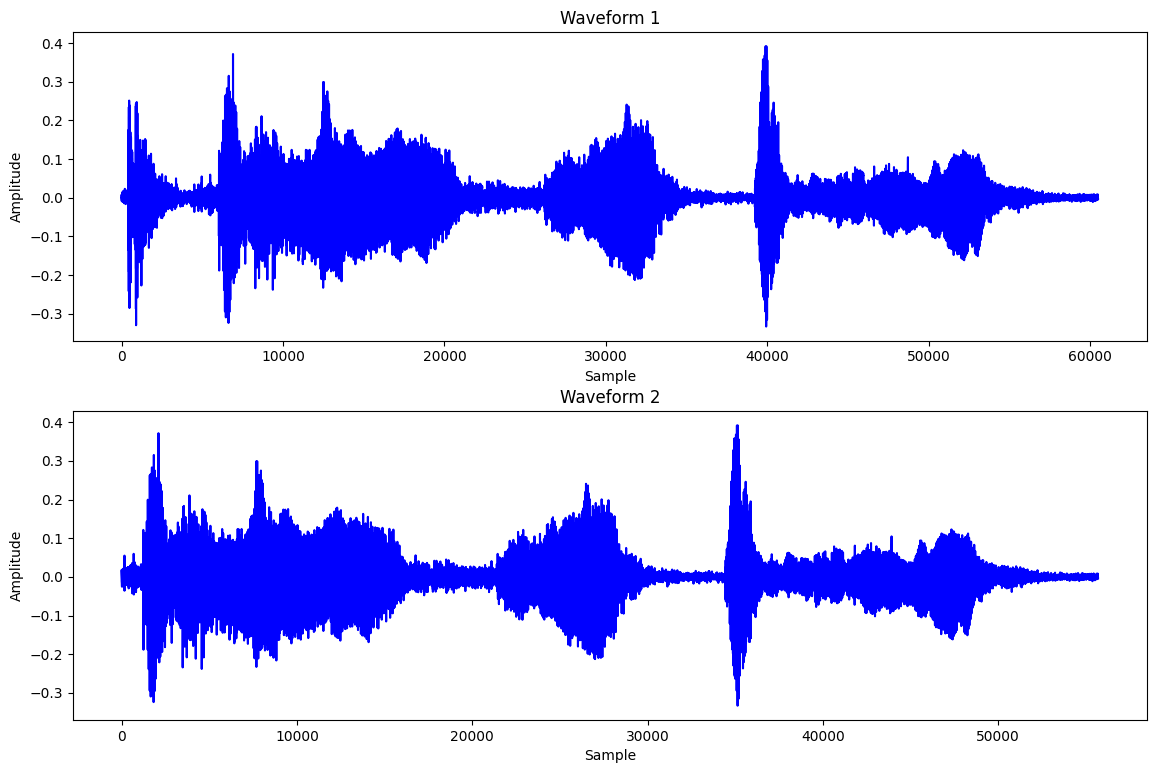

In [21]:
import matplotlib.pyplot as plt
import torchaudio

def plot_waveforms(waveforms):
    fig, axes = plt.subplots(len(waveforms), 1, figsize=(12, 8))
    fig.tight_layout(pad=3.0)  # Увеличиваем расстояние между графиками

    for i, waveform in enumerate(waveforms):
        axes[i].plot(waveform, color='blue')
        axes[i].set_title(f"Waveform {i+1}")
        axes[i].set_xlabel("Sample")
        axes[i].set_ylabel("Amplitude")

    plt.show()


plot_waveforms([original.view(-1), processed_torchaudio.view(-1)])